# Predicting Titanic Survivors

This is my attempt at predicting who survived the Titanic disaster. It is in response to the competition set on <a href="https://www.kaggle.com/c/titanic" target="_blank">kaggle</a>.

It has enabled me to learn more about machine learning.

## Importing Libraries

The first thing my program does is import the various libraries and functions I need.

In [12]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import category_encoders as ce
import itertools

from numpy import set_printoptions
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Setting up the Data Frames

Next, I import the data and put them into X_full and y. X_full does not contain the 'Survived' column because the values in it are the ones I am trying to predict. These values are stored in y.

I drop 'PassengerId' from X_full as I don't think the passenger Id numbers would have any connection to whether or not a person survived.

Then, I split the data into a training set of 80% and a validation set of 20%. I do this before I preprocess the data so as to avoid any data leakage which would give me unreliable results.

In [13]:
# main
# load the data
data_set = pd.read_csv('/home/bodhi/Documents/Jupyter/Titanic/train.csv')

# set up X_full and y
X_full = data_set.drop(columns=['Survived', 'PassengerId']).copy()
y = data_set.Survived.copy()

# split the data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y,
                                                                test_size=0.2,
                                                                random_state=1).copy()

## Deal With Preprocessing of Data

Next, I set up pipelines to deal with the preprocessing of categorical and numerical features.

The categorical features have Nan types filled with the most frequent value before they are count-encoded.

The numerical features have Nan types filled with the median value of their column before they are standardized and normalized.

I also create an initial model and put it into a pipeline.

In [14]:
# select numerical columns which need to be preprocessed
numerical_cols = [cname for cname in X_train_full.columns if
                 X_train_full[cname].dtype in ['int64', 'float64']
                 ]

# select categorical columns which need to be preprocessed
categorical_cols = [cname for cname in X_train_full.columns
                  if X_train_full[cname].nunique() < 10 and
                  X_train_full[cname].dtype == 'object'
                   ]

# preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('count_enc', ce.CountEncoder())
]
                                  )

# preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler()),
    ('normalize', MinMaxScaler())
]
                                   )

# set up the initial model
model = XGBClassifier()

# put the model into a pipeline
pipe = Pipeline(steps=[('model', model)
                      ]
               )

## Transforming the Training Data

Now, I use a function to transform the training data. This function uses the pipelines created earlier to preprocess the categorical and numerical features found in the training data.

The function uses a parameter to recognise if it is working on the training data or not. If it is working on the training data, it fits the preprocessing pipelines to the data before transforming it.

If it is not working on the training data, it must be working on the validation or test data. This means that it only transforms the data using the pipelines which have been fitted to the training data. This is to eliminate data leakage.

In [15]:
def transform(df, split):
    # impute missing categorical data and count encode it
    set_cats = pd.DataFrame(df[categorical_cols])
    if split == 'train':
        set_cats = categorical_transformer.fit_transform(set_cats)
    else:
        set_cats = categorical_transformer.transform(set_cats)
    set_cats.columns = categorical_cols
    set_cats.index = df.index
    
    # impute missing numerical data
    imputed_df_nums = pd.DataFrame(df[numerical_cols])
    if split == 'train':
        imputed_df_nums = numerical_transformer.fit_transform(imputed_df_nums)
    else:
        imputed_df_nums = numerical_transformer.transform(imputed_df_nums)
    imputed_df_nums = pd.DataFrame(imputed_df_nums, columns=[numerical_cols])
    imputed_df_nums.index = df.index

    # create a new data frame using the transformed training data
    frames = [set_cats, imputed_df_nums]
    baseline = set_cats.join(imputed_df_nums, how='inner')
    return baseline

# transform the training data with imputation and count encoding
baseline_train = transform(X_train_full, 'train')

## Create New Interactions

Next, new interactions are created by combining each categorical feature with another categorical feature.

The new interactions are joined to the original data frame.

In [16]:
def get_interactions(baseline):
    # create interactions by combining categorical features
    interactions = pd.DataFrame(index=baseline.index)
    for col1, col2 in itertools.combinations(categorical_cols, 2):
        new_col_name = '_'.join([col1, col2])
        # combine
        new_values = baseline[col1] - baseline[col2]
        interactions[new_col_name] = new_values
    return interactions

# create new interactions
new_features = get_interactions(baseline_train)

# combine the transformed numerical and categorical data
baseline_train = baseline_train.join(new_features)

## Finding the Best Features

Now, we find the best number of features using SelectKBest. Linear relationships gave better results than when I included non-linear ones, so I use f_classif.

This part of the program returns the smallest number for k which has the best score.

A new data frame is created (X_train_best) which only uses the best features (as found using SelectKBest).

In [17]:
def get_best(k):
    # keep best features
    selector = SelectKBest(f_classif, k=k)
    X_new = selector.fit_transform(baseline_train, y_train)
    
    # get back the best features and zero out all the others
    selected_features = pd.DataFrame(selector.inverse_transform(X_new),
                                     index=baseline_train.index,
                                     columns=feature_cols)

    # features other than the best ones have values of 0s, so var is 0 - drop them
    selected_columns = selected_features.columns[selected_features.var() != 0]
    return selected_columns

def get_k():
    k = 1
    results = []
    while k <= 7:
        best_columns = get_best(k)
        test_best = baseline_train[best_columns].copy()
        results.append(cross_val_score(pipe, test_best, y_train, scoring='accuracy').mean())
        k+=1
    return (results.index(max(results))) + 1

# find the best number of features (k)
feature_cols = baseline_train.columns
k = get_k()

# find the best features
best_columns = get_best(k)

# create an X_train set of data which uses only the best features
X_train_best = baseline_train[best_columns]

## Preparing the Validation Data

The validation part of the original data is now preprocessed and new interactions are found for it. A new data frame is created (X_valid_best) which only uses the best features (as found using SelectKBest on the training data earlier).

In [18]:
# transform the validation data with imputation and count encoding
baseline_valid = transform(X_valid_full, 'valid')

# create new interactions
new_features_valid = get_interactions(baseline_valid)

# combine the transformed numerical and categorical data
baseline_valid = baseline_valid.join(new_features_valid)

# create an X_valid set of data which uses only the best features
X_valid_best = baseline_valid[best_columns]

## Spot Check Algorithms

We are now ready to spot-check linear, non-linear and ensemble classifiers. The mean results are printed along with the standard deviation.

To make the performances easier to understand, a box-plot is created.

LDA: 0.796405 (0.020735)
KNN-: 0.799222 (0.023184)
CART: 0.754309 (0.030597)
RF: 0.823146 (0.039057)
XGB: 0.828721 (0.025663)
SVM: 0.613799 (0.016887)


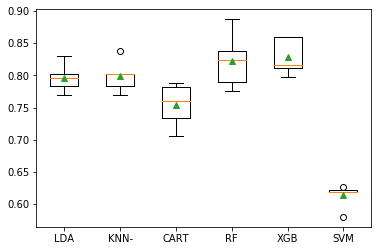

In [19]:
def get_models(models=[]):
    # linear models
    models.append(('LDA', LinearDiscriminantAnalysis()))
    
    # non-linear models
    models.append(('KNN-', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    
    # ensemble models
    models.append(('RF', RandomForestClassifier()))
    models.append(('XGB', XGBClassifier()))
    models.append(('SVM', SVC()))
    
    return models

def spot_check():
    models = get_models()
    # evaluate each model in turn
    results = []
    names = []
    for name, classifier in models:
        pipe.set_params(model = classifier)
        cv_results = cross_val_score(pipe, X_train_best, y_train,scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    # plot model performance for comparison
    plt.boxplot(results, labels=names, showmeans=True)
    plt.show()
    
# spot-check algorithms and show performances
spot_check()

## Grid Search

I continue to use XGBoost as it performs the best on the training data.

Using grid search, I hyper-tune some basic parameters.

The best model is created using the best values found for the basic parameters.

## Test the Best Model on the Validation Data

The best model is then used to make predictions about the validation data and an accuracy score returned.

## Load the Test Data and Make the Final Predictions

Next, the test data is loaded and preprocessed. New interactions are created and the best model uses the best features to make predictions for the test data.

Finally, the predictions are turned into an excel file and saved.

In [21]:
def grid_search():
    print('Tuning...')
    pipe.set_params(model=XGBClassifier())
    param_grid = dict(model__learning_rate=[0.1],
                      model__n_estimators=[500]
                     )
    grid = GridSearchCV(pipe,
                        param_grid=param_grid,
                        cv=3,
                        scoring='accuracy')
    grid.fit(X_train_best, y_train)
    print(grid.best_params_)
    return grid

# search for the best parameters using gridsearch and
# create the best model using the best parameters
grid = grid_search()

best_learning = grid.best_params_['model__learning_rate']
best_estimators = grid.best_params_['model__n_estimators']

pipe.set_params(model=XGBClassifier(learning_rate=best_learning,
                                   n_estimators=best_estimators
                                   )
               )

# use the best model to make a prediciton on validation data
best_model = pipe.fit(X_train_best, y_train)
y_pred = best_model.predict(X_valid_best)
print('\nBest Model Accuracy Score:', metrics.accuracy_score(y_valid, y_pred))

# load the new data
mystery_data_set = pd.read_csv('/home/bodhi/Documents/Jupyter/Titanic/test_4.csv')

mx = mystery_data_set.copy()

# transform the training data with imputation and count encoding
baseline_test = transform(mx, 'test')

# create new interactions
new_features = get_interactions(baseline_test)

# combine the transformed numerical and categorical data
baseline_test = baseline_test.join(new_features)

# create an X_test set of data which uses only the best features
X_test_best = baseline_test[best_columns]

# predict the final values
preds = best_model.predict(X_test_best)

# load the submission information
my_solution = pd.DataFrame({'PassengerId':mystery_data_set['PassengerId'],
                                'Survived':preds})

my_solution.to_excel('/home/bodhi/Documents/Jupyter/Titanic/tt_2.xls')
print('Saved!')

Tuning...
{'model__learning_rate': 0.1, 'model__n_estimators': 500}

Best Model Accuracy Score: 0.7932960893854749
Saved!


## Results?

I submitted the predictions to the <a href="https://www.kaggle.com/c/titanic" target="_blank">kaggle</a> competition and scored:

0.76076

## Improving Accuracy

I think that the best way to improve accuracy would be to look again at the data. I have noticed that the feature 'Parch' combines data about whether or not a passenger had any parents or children. I think these data would be better if they were seperated. In order to do this, I will need to do some online research. It might increase the accuracy of my program!